## Acquiring the data

In [1]:
import numpy as np
import pandas as pd
import glob

#Adding relative path name to data variable. Dataset suffix is data when it's available

data = [i for i in glob.glob('../data/data*.csv')]
    
#Rows skipped to avoid additional cleaning, dates parsed and date used as the index

MM = pd.read_csv(data[0], skiprows=[1, 483], header= 0, 
                 na_values=0, parse_dates=['Payouts Payout Currency'], 
                 index_col='Payouts Payout Currency').rename_axis(None)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
#This function sets the beginning of the time series based on first 3 consecutives weeks without FX MM
def series_begins(x):
    nan_index = x.index[x.isnull()]
    for i in range(0,len(nan_index)):
        upper = i + 2
        difference = nan_index[i] - nan_index[(upper)]
        if difference.days == 14:
            return nan_index[i]


In [ ]:
#This function sets the end of the time series based on last 2 consecutives weeks with FX MM
def series_ends(x):
    notnan_index = x.index[x.notna()]
    for i in range(0,len(notnan_index)):
        notnan_upper = i + 1
        notnan_difference = notnan_index[i] - notnan_index[(notnan_upper)]
        if notnan_difference.days == 7:
            return notnan_index[i]

In [ ]:
def series_ends_begins(x):
    ends_begins = []
    notnan_index = x.index[x.notna()]
    for i in range(0,len(notnan_index)):
        notnan_upper = i + 1
        notnan_difference = notnan_index[i] - notnan_index[(notnan_upper)]
        if notnan_difference.days == 7:
            ends_begins.append(notnan_index[i])
            nan_index = x.loc[ends_begins[0]:].index[x.loc[ends_begins[0]:].isnull()]
            for i in range(0,len(nan_index)):
                upper = i + 2
                difference = nan_index[i] - nan_index[(upper)]
                if difference.days == 14:
                    ends_begins.append(nan_index[i])
                    return ends_begins
                
                
type(series_ends_begins(MM['GBP']))

In [2]:
"""
This function lists the end, based on last 2 consecutives weeks with FX MM
and the start, based on on first 3 consecutives weeks without FX MM, of the timeseries.
"""


def series_end_start(x):
    end_start = [0,0]
    notnan_index = x.index[x.notna()]
    for i in range(0,len(notnan_index)):
        notnan_upper = i + 1
        notnan_difference = notnan_index[i] - notnan_index[(notnan_upper)]
        if notnan_difference.days == 7:
            end_start[0] = notnan_index[i]
            nan_index = x.loc[end_start[0]:].index[x.loc[end_start[0]:].isnull()]
            for i in range(0,len(nan_index)):
                upper = i + 2
                difference = nan_index[i] - nan_index[(upper)]
                if difference.days == 14:
                    end_start[1] = nan_index[i]
                    return end_start

In [ ]:
series_end_start(MM['PEN'])

In [ ]:
series_ends_begins(MM['KRW'])

In [ ]:
series = [0,0]
series[1] = 1
series

In [ ]:
#Beginning dates are passed on a dictionary per feature in the data set

dict_series_begings = {i:series_begins(MM[i]) for i in MM.columns}

In [3]:
#Series end and start dates are passed on to dictionary

dict_series_end_start = {i:series_end_start(MM[i]) for i in MM.columns}

In [ ]:
dict_series_end_start

In [ ]:
MM.loc[dict_series_end_start['USD'][0]:dict_series_end_start['USD'][1],'USD'].iloc[:-1]

In [4]:
#The function creates a data frame bounded by the end and start of the series

def get_df(x):
    try:
        series = MM.loc[dict_series_end_start[x][0]:dict_series_end_start[x][1],x].iloc[:-1].fillna(0)
        df_output = series.reset_index().rename({'index':'ds', x:'y'}, axis=1)

        return df_output
    except:
        return print(f"There isn't enough historic data to predict {x} volumes or {x} is not a valid market.")

In [ ]:
get_df('GUA')

In [5]:
from matplotlib import pyplot as plt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import add_changepoints_to_plot

In [6]:
#This function creates the forecast and plots it

def plot_forecast(market, period, frequency):
    model = fit_model_kwargs(market)
    
    future = model.make_future_dataframe(periods=period, freq=frequency)
    forecast = model.predict(future)
    forecast[['yhat', 'yhat_lower']] = forecast[['yhat', 'yhat_lower']].clip(0,)
    
    fig = model.plot_components(forecast)
    fig = model.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [28]:
def get_test_val(x):
    return round(len(get_df(x)) * grid[x]['initial'])

In [ ]:
get_baseline_x_val('GBP')

In [ ]:
"""
Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
"""

In [298]:
MM['AUD'].sort_values(ascending=False)

2019-07-22    1.579324e+07
2020-03-02    1.143902e+07
2020-02-24    1.064045e+07
2019-07-29    1.032915e+07
2019-07-15    9.596717e+06
                  ...     
2011-01-31             NaN
2011-01-24             NaN
2011-01-17             NaN
2011-01-10             NaN
NaT                    NaN
Name: AUD, Length: 482, dtype: float64

In [ ]:
model_error_kwargs('AUD', 4, 13, 'W')

INFO:fbprophet:Making 13 forecasts with cutoffs between 2018-12-31 00:00:00 and 2019-12-02 00:00:00


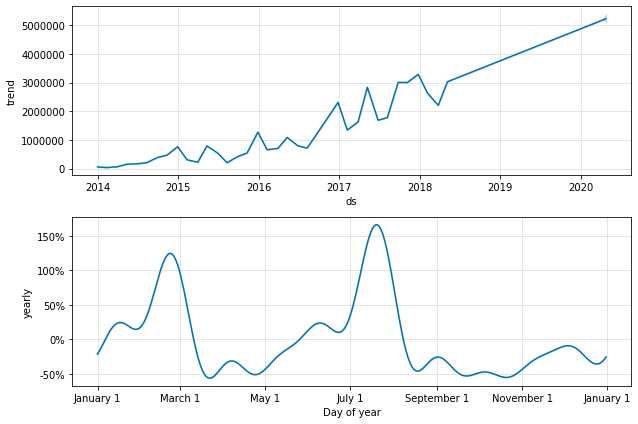

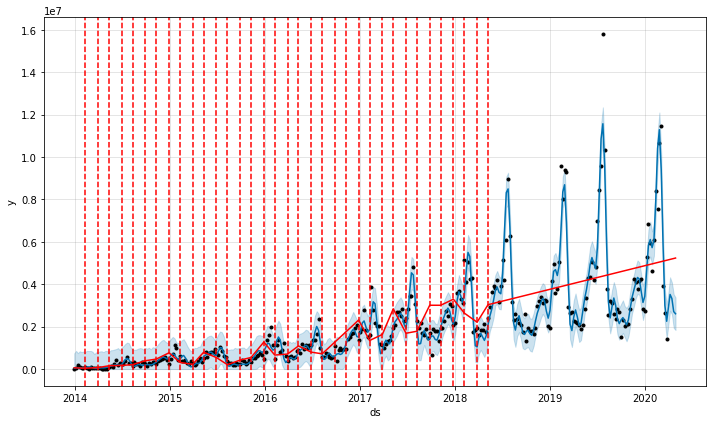

In [341]:
plot_forecast('AUD', 5, 'W')

In [ ]:
#This function fits the model and creates the forecast

def create_forecast(market, period, frequency):
    model = fit_model(market)
    
    future = model.make_future_dataframe(periods=period, freq=frequency)
    forecast = model.predict(future)
    forecast[['yhat', 'yhat_lower']] = forecast[['yhat', 'yhat_lower']].clip(0,)
    
    return forecast


In [ ]:
#This function fits the model

def fit_model(market):
    X = get_df(market)
    model = Prophet(daily_seasonality=False, weekly_seasonality=False, 
                    holidays=covid, n_changepoints=25, changepoint_range=0.8, 
                    seasonality_mode='multiplicative', holidays_prior_scale=10.0, 
                    changepoint_prior_scale=10)
    return model.fit(X)

In [345]:
#This function fits the model based on grid

def fit_model_kwargs(market):
    X = get_df(market)
    if market in ['GBP', 'EUR', 'CAD', 'USD', 'AUD']:
        X.loc[X['ds'] > '2020-03-02', 'y'] = None
    model = Prophet(**grid[market]['params'])
    return model.fit(X)

In [342]:
#Baseline grid
grid = {'GBP':{'params':{'daily_seasonality':False, 'weekly_seasonality':False, 
             'holidays':None, 'n_changepoints':25, 'changepoint_range':0.8, 
             'seasonality_mode':'multiplicative', 'holidays_prior_scale':10.0, 
             'changepoint_prior_scale':0.5},
               'initial':0.8},

        'AUD':{'params':{'daily_seasonality':False, 'weekly_seasonality':False, 
                         'holidays':None, 'n_changepoints':35, 
                         'changepoint_range':0.7, 'seasonality_mode':'multiplicative', 
                         'holidays_prior_scale':10, 'seasonality_prior_scale':40, 
                         'changepoint_prior_scale':40},
               'initial':0.8},

        'CAD':{'params':{'daily_seasonality':False, 'weekly_seasonality':False, 
                         'holidays':None, 'n_changepoints':34, 'changepoint_range':0.85, 
                         'seasonality_mode':'multiplicative', 'seasonality_prior_scale':0.05, 
                         'holidays_prior_scale':10.0, 'changepoint_prior_scale':0.5},
               'initial':0.8},

        'EUR':{'params':{'daily_seasonality':False, 'weekly_seasonality':False, 
             'holidays':None, 'n_changepoints':34, 'changepoint_range':0.8, 
             'seasonality_mode':'multiplicative', 'holidays_prior_scale':10.0, 
             'changepoint_prior_scale':0.5},
               'initial':0.8},

        'JPY':{'params':{'daily_seasonality':False, 'weekly_seasonality':False, 
             'holidays':covid, 'n_changepoints':34, 'changepoint_range':0.8, 
             'seasonality_mode':'multiplicative', 'holidays_prior_scale':10.0, 
             'changepoint_prior_scale':0.05},
               'initial':0.71},
        
        'SGD':{'params':{'daily_seasonality':False, 'weekly_seasonality':False, 
             'holidays':covid, 'n_changepoints':34, 'changepoint_range':0.8, 
             'seasonality_mode':'multiplicative', 'holidays_prior_scale':10.0, 
             'changepoint_prior_scale':5},
               'initial':0.63},
        
        'HKD':{'params':{'daily_seasonality':False, 'weekly_seasonality':False, 
             'holidays':covid, 'n_changepoints':25, 'changepoint_range':0.6, 
             'seasonality_mode':'multiplicative', 'holidays_prior_scale':0.1, 
             'changepoint_prior_scale':20},
               'initial':0.76},

        'USD':{'params':{'daily_seasonality':False, 'weekly_seasonality':False, 
             'holidays':None, 'n_changepoints':34, 'changepoint_range':0.8, 
             'seasonality_mode':'multiplicative', 'holidays_prior_scale':10.0, 
             'changepoint_prior_scale':5},
              'initial':0.86}}

In [317]:
#Holiday factor
covid = pd.DataFrame({
  'holiday': 'covid',
  'ds': pd.to_datetime(['2020-03-23', '2020-03-16', '2020-03-09',
                        '2020-03-02']),
  'lower_window': 0,
  'upper_window': 0,
})

In [146]:
best_initials = [grid[i]['initial'] for i in grid.keys()]

In [160]:
best_initials

[0.65, 0.9, 0.65, 0.9, 0.65, 0.9, 0.9, 0.9]

In [ ]:
#This function fits the model & x-validates it

def model_error(market, baseline_days, cutoff, fcst, units):
    model = fit_model_kwargs(market, grid)

    
    cv_results = cross_validation(model=model, initial=pd.to_timedelta(baseline_days, unit=units), 
                              period=pd.to_timedelta(cutoff, unit=units), 
                              horizon=pd.to_timedelta(fcst, unit=units))
    cv_results[['yhat', 'yhat_lower']] = cv_results[['yhat', 'yhat_lower']].clip(0,)
    
    mape = mean_absolute_percentage_error(cv_results.y, cv_results.yhat)
    
    return mape

In [10]:
##This function fits the model with particular grid & x-validates it
def model_error_kwargs(market, cutoff, fcst, units):
    model = fit_model_kwargs(market)

    
    cv_results = cross_validation(model=model, initial=pd.to_timedelta(get_test_val(market), unit=units), 
                              period=pd.to_timedelta(cutoff, unit=units), 
                              horizon=pd.to_timedelta(fcst, unit=units))
    cv_results[['yhat', 'yhat_lower']] = cv_results[['yhat', 'yhat_lower']].clip(0,)
    
    mape = mean_absolute_percentage_error(cv_results.y, cv_results.yhat)
    
    return mape

In [181]:
#Having log transform
for i in grid.keys():
    result = model_error_kwargs(i, 4, 13, 'W')
    print(f'{i} error is {result}')

INFO:fbprophet:Making 13 forecasts with cutoffs between 2018-12-31 00:00:00 and 2019-12-02 00:00:00


GBP error is 11.348800027436829


INFO:fbprophet:Making 13 forecasts with cutoffs between 2019-01-21 00:00:00 and 2019-12-23 00:00:00


AUD error is 23.9584238330063


INFO:fbprophet:Making 13 forecasts with cutoffs between 2018-12-31 00:00:00 and 2019-12-02 00:00:00


CAD error is 25.23587654081186


INFO:fbprophet:Making 13 forecasts with cutoffs between 2018-12-31 00:00:00 and 2019-12-02 00:00:00


EUR error is 11.559601171833332


INFO:fbprophet:Making 13 forecasts with cutoffs between 2019-01-21 00:00:00 and 2019-12-23 00:00:00


JPY error is 45.80568299528856


INFO:fbprophet:Making 13 forecasts with cutoffs between 2019-01-21 00:00:00 and 2019-12-23 00:00:00


SGD error is 56.70652658071948


INFO:fbprophet:Making 13 forecasts with cutoffs between 2019-01-21 00:00:00 and 2019-12-23 00:00:00


HKD error is 90.73152068936653


INFO:fbprophet:Making 13 forecasts with cutoffs between 2018-12-31 00:00:00 and 2019-12-02 00:00:00


USD error is 13.536096294603722


In [134]:
for i in grid.keys():
    result = model_error_kwargs(i, 5, 13, 'W')
    print(f'{i} error is {result}')

INFO:fbprophet:Making 20 forecasts with cutoffs between 2018-02-05 00:00:00 and 2019-12-02 00:00:00


GBP error is 11.493449621348622


INFO:fbprophet:Making 4 forecasts with cutoffs between 2019-09-09 00:00:00 and 2019-12-23 00:00:00


AUD error is 22.665657695187345


INFO:fbprophet:Making 20 forecasts with cutoffs between 2018-02-05 00:00:00 and 2019-12-02 00:00:00


CAD error is 20.23030907731253


INFO:fbprophet:Making 4 forecasts with cutoffs between 2019-08-19 00:00:00 and 2019-12-02 00:00:00


EUR error is 9.750170490681947


INFO:fbprophet:Making 13 forecasts with cutoffs between 2018-10-29 00:00:00 and 2019-12-23 00:00:00


JPY error is 43.71235813690657


INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-12-23 00:00:00 and 2019-12-23 00:00:00


SGD error is 53.062119130141916


INFO:fbprophet:Making 3 forecasts with cutoffs between 2019-10-14 00:00:00 and 2019-12-23 00:00:00


HKD error is 56.26034692762829


INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-05-06 00:00:00 and 2019-12-02 00:00:00


USD error is 12.855899415985808


In [ ]:
model_error_kwargs('GBP', 208, 21, 21, 'W')

In [ ]:
?Prophet.make_future_dataframe

In [ ]:
#This function cross validates the forecasts based on certain baseline, cutoff
#forecast and units ('M', 'W', 'D') desired to measure it

def cross_val(baseline, cutoff, fcst, units):
    cv_results = cross_validation(model=m, initial=pd.to_timedelta(baseline, unit=units), 
                              period=pd.to_timedelta(cutoff, unit=units), 
                              horizon=pd.to_timedelta(fcst, unit=units))
    return cv_results

In [ ]:
#Cross Validation

from fbprophet.diagnostics import cross_validation

cv_results = cross_validation(model=m, initial=pd.to_timedelta(208, unit="W"), 
                              period=pd.to_timedelta(21, unit="W"), 
                              horizon=pd.to_timedelta(21, unit="W"))

cv_results.head()

In [194]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 1)

In [ ]:
mean_absolute_percentage_error(cv_results.y, cv_results.yhat)

In [ ]:
?plot_cross_validation_metric

In [ ]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

df_p = performance_metrics(cv_results)

fig = plot_cross_validation_metric(cv_results, metric='mape')

In [ ]:
?performance_metrics

In [ ]:
from fbprophet.diagnostics import performance_metrics


df_p = performance_metrics(cv_results)
df_p

In [ ]:
plot_forecast('JPY', 5, 'W')

In [ ]:
for i in ['AUD', 'CAD', 'EUR', 'GBP', 'JPY', 'USD']:
    create_forecast(i, 10, 'W')

#create_forecast('CAD', 10, 'W')

In [ ]:
from fbprophet.plot import add_changepoints_to_plot

baseline = get_df('AUD')
m = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.5)


m.fit(baseline)
futures = m.make_future_dataframe(periods=13, freq='W')
forecast = m.predict(futures)
#print(futures.tail(13))
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
print(m.changepoints)

In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()


## Cleaning Data